<a href="https://colab.research.google.com/github/YIMDOBIN/CT_reconstruction_via_DL/blob/master/%EB%A6%AC%EC%BB%A8_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from google.colab import files
src = list(files.upload().values())[0]
open('utils.py','wb').write(src)
import utils

Saving utils.py to utils (1).py


In [4]:
from utils import l2_and_gradient_loss
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow import keras

In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
x_train = np.load('/content/gdrive/MyDrive/X_train.npy')
y_train = np.load('/content/gdrive/MyDrive/y_train.npy')
x_test = np.load('/content/gdrive/MyDrive/X_test.npy')
y_test = np.load('/content/gdrive/MyDrive/y_test.npy')

In [8]:
def get_session():

    gpu_fraction = 0.9
    visible_device_list = 0,1
    
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction,visible_device_list=visible_device_list)


    return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [9]:

### 모델 설정 ###

model = Sequential()

model.add(Dense(64*64,input_shape=(2*95*90,),activation='tanh'))
model.add(Dense(64*64,activation='tanh'))
model.add(Reshape((64,64,1),input_shape=(64*64,)))
model.add(Conv2D(64,[5,5],padding='same',activation='relu'))
model.add(Conv2D(64,[5,5],padding='same',activation='relu'))
model.add(Conv2DTranspose(1,[7,7],padding='same'))

In [10]:

model.compile(loss=l2_and_gradient_loss, optimizer=Adam(lr=0.0001))

In [ ]:
history = model.fit(x_train, y_train, epochs=300, validation_data=(x_test, y_test))
print(history.history)

In [ ]:
# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
pip install phantominator

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Image dtype is not float. By default radon will assume you want to preserve the range of your image (preserve_range=True). In scikit-image 0.18 this behavior will change to preserve_range=False. To avoid this warning, explicitly specify the preserve_range parameter.


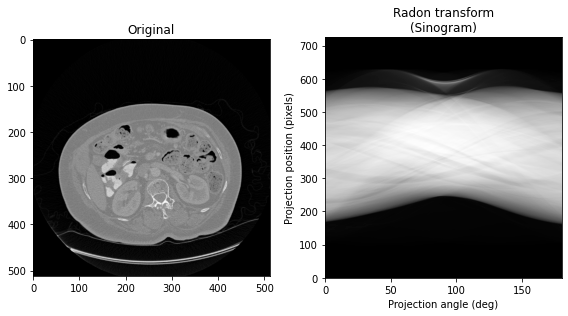

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale
#from phantominator import shepp_logan
import cv2
#image = shepp_logan(512)
image = imread('/content/gdrive/MyDrive/radio_science_dataset/1.png', as_gray=True)
#image = rescale(image, scale=1, mode='reflect', multichannel=False)
#image = cv2.flip(image, 0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
  
ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0, 180, max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta, circle=False)

#sinogram = cv2.resize(sinogram, dsize=(180, 512), interpolation=cv2.INTER_AREA)
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

fig.tight_layout()
plt.show()

#image_save = imsave('/content/gdrive/MyDrive/radio_science_dataset/1_1.png', image)

#image_save = imsave('/content/gdrive/MyDrive/radio_science_dataset/sinogram.png', sinogram)

FBP rms reconstruction error: 2.9


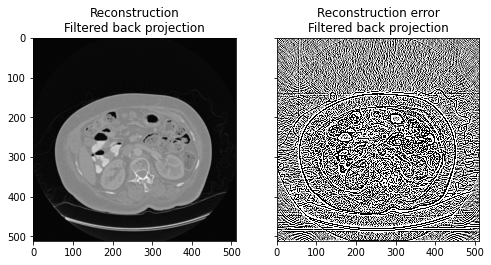

time : 2.045931100845337


In [ ]:
import time
from skimage.transform import iradon
import cv2

start = time.time()  # 시작 시간 저장

reconstruction_fbp = iradon(sinogram, theta=theta, circle=False)
error = reconstruction_fbp - image
print(f"FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}")

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5),
                               sharex=True, sharey=True)

ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

image_save = imsave('/content/gdrive/MyDrive/radio_science_dataset/180.png', reconstruction_fbp)

image_save = imsave('/content/gdrive/MyDrive/radio_science_dataset/180_error.png', error)
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

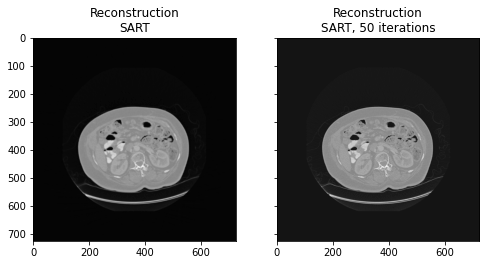

time : 1127.981787443161
FBP rms reconstruction error: 2.9


In [ ]:
import time
start = time.time()  # 시작 시간 저장

from skimage.transform import iradon_sart

reconstruction_sart = iradon_sart(sinogram, theta=theta)
#cv2.imwrite('/content/gdrive/My Drive/NIMA/lenagray.png', reconstruction_sart)
#image_save = imsave('/content/gdrive/My Drive/CTrecon/180SART.png', reconstruction_sart)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)

ax1.set_title("Reconstruction\nSART")
ax1.imshow(reconstruction_sart, cmap=plt.cm.Greys_r)

# Run a second iteration of SART by supplying the reconstruction
# from the first iteration as an initial estimate
reconstruction_sart2 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart)

reconstruction_sart3 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart2)

reconstruction_sart4 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart3)


reconstruction_sart5 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart4)


reconstruction_sart6 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart5)


reconstruction_sart7 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart6)


reconstruction_sart8 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart7)


reconstruction_sart9 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart8)


reconstruction_sart10 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart9)


reconstruction_sart11 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart10)

reconstruction_sart12 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart11)


reconstruction_sart13 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart12)


reconstruction_sart14 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart13)


reconstruction_sart15 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart14)

reconstruction_sart16 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart15)

reconstruction_sart17 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart16)

reconstruction_sart18 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart17)

reconstruction_sart19 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart18)

reconstruction_sart20 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart19)

reconstruction_sart21 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart20)

reconstruction_sart22 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart21)

reconstruction_sart23 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart22)

reconstruction_sart24 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart23)

reconstruction_sart25 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart24)

reconstruction_sart26 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart25)

reconstruction_sart27 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart26)

reconstruction_sart28 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart27)

reconstruction_sart29 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart28)

reconstruction_sart30 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart29)

reconstruction_sart31 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart30)

reconstruction_sart32 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart31)

reconstruction_sart33 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart32)

reconstruction_sart34 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart33)

reconstruction_sart35 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart34)

reconstruction_sart36 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart35)

reconstruction_sart37 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart36)

reconstruction_sart38 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart37)

reconstruction_sart39 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart38)

reconstruction_sart40 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart39)

reconstruction_sart41 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart40)

reconstruction_sart42 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart41)

reconstruction_sart43 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart42)

reconstruction_sart44 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart43)
reconstruction_sart45 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart44)

reconstruction_sart46 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart45)

reconstruction_sart47 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart46)

reconstruction_sart48 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart47)
reconstruction_sart49 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart48)
reconstruction_sart50 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart49)
ax2.set_title("Reconstruction\nSART, 50 iterations")
ax2.imshow(reconstruction_sart50, cmap=plt.cm.Greys_r)
plt.show()
image_save = imsave('/content/gdrive/MyDrive/radio_science_dataset/150SART.png', reconstruction_sart50)

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

error = reconstruction_fbp - image
print(f"FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}")


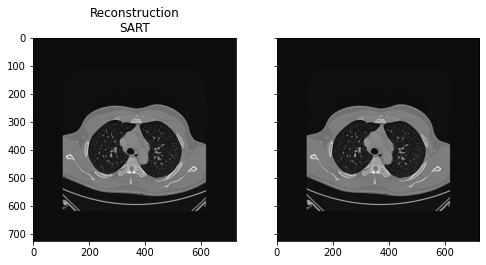

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)

ax1.set_title("Reconstruction\nSART")
ax1.imshow(reconstruction_sart, cmap=plt.cm.Greys_r)
ax2.imshow(reconstruction_sart50, cmap=plt.cm.Greys_r)
plt.show()

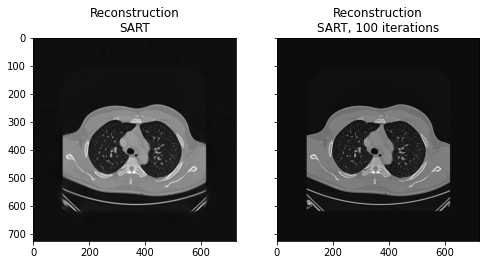

time : 2263.6591651439667


In [ ]:
import time
start = time.time()  # 시작 시간 저장

from skimage.transform import iradon_sart

reconstruction_sart = iradon_sart(sinogram, theta=theta)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)

ax1.set_title("Reconstruction\nSART")
ax1.imshow(reconstruction_sart, cmap=plt.cm.Greys_r)

# Run a second iteration of SART by supplying the reconstruction
# from the first iteration as an initial estimate
reconstruction_sart2 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart)

reconstruction_sart3 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart2)

reconstruction_sart4 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart3)


reconstruction_sart5 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart4)


reconstruction_sart6 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart5)


reconstruction_sart7 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart6)


reconstruction_sart8 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart7)


reconstruction_sart9 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart8)


reconstruction_sart10 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart9)


reconstruction_sart11 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart10)

reconstruction_sart12 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart11)


reconstruction_sart13 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart12)


reconstruction_sart14 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart13)


reconstruction_sart15 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart14)

reconstruction_sart16 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart15)

reconstruction_sart17 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart16)

reconstruction_sart18 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart17)

reconstruction_sart19 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart18)

reconstruction_sart20 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart19)

reconstruction_sart21 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart20)

reconstruction_sart22 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart21)

reconstruction_sart23 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart22)

reconstruction_sart24 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart23)

reconstruction_sart25 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart24)

reconstruction_sart26 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart25)

reconstruction_sart27 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart26)

reconstruction_sart28 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart27)

reconstruction_sart29 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart28)

reconstruction_sart30 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart29)

reconstruction_sart31 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart30)

reconstruction_sart32 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart31)

reconstruction_sart33 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart32)

reconstruction_sart34 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart33)

reconstruction_sart35 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart34)

reconstruction_sart36 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart35)

reconstruction_sart37 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart36)

reconstruction_sart38 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart37)

reconstruction_sart39 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart38)

reconstruction_sart40 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart39)

reconstruction_sart41 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart40)

reconstruction_sart42 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart41)

reconstruction_sart43 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart42)

reconstruction_sart44 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart43)
reconstruction_sart45 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart44)

reconstruction_sart46 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart45)

reconstruction_sart47 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart46)

reconstruction_sart48 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart47)
reconstruction_sart49 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart48)
reconstruction_sart50 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart49)
reconstruction_sart51 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart50)
reconstruction_sart52 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart51)
reconstruction_sart53 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart52)
reconstruction_sart54 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart53)
reconstruction_sart55 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart54)
reconstruction_sart56 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart55)
reconstruction_sart57 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart56)
reconstruction_sart58 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart57)
reconstruction_sart59 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart58)
reconstruction_sart60 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart59)
reconstruction_sart61 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart60)
reconstruction_sart62 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart61)
reconstruction_sart63 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart62)
reconstruction_sart64 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart63)
reconstruction_sart65 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart64)
reconstruction_sart66 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart65)
reconstruction_sart67 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart66)
reconstruction_sart68 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart67)
reconstruction_sart69 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart68)
reconstruction_sart70 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart69)
reconstruction_sart71 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart70)
reconstruction_sart72 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart71)
reconstruction_sart73 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart72)
reconstruction_sart74 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart73)
reconstruction_sart75 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart74)
reconstruction_sart76 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart75)
reconstruction_sart77 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart76)
reconstruction_sart78 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart77)
reconstruction_sart79 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart78)
reconstruction_sart80 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart79)
reconstruction_sart81 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart80)
reconstruction_sart82 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart81)
reconstruction_sart83 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart82)
reconstruction_sart84 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart83)
reconstruction_sart85 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart84)
reconstruction_sart86 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart85)
reconstruction_sart87 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart86)
reconstruction_sart88 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart87)
reconstruction_sart89 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart88)
reconstruction_sart90 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart89)
reconstruction_sart91 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart90)
reconstruction_sart92 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart91)
reconstruction_sart93 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart92)
reconstruction_sart94 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart93)
reconstruction_sart95 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart94)
reconstruction_sart96 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart95)
reconstruction_sart97 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart96)
reconstruction_sart98 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart97)
reconstruction_sart99 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart98)
reconstruction_sart100 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart99)

ax2.set_title("Reconstruction\nSART, 100 iterations")
ax2.imshow(reconstruction_sart100, cmap=plt.cm.Greys_r)
plt.show()
image_save = imsave('/content/gdrive/My Drive/NIMA/100SART.png', reconstruction_sart)
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

In [ ]:
image_save = imsave('/content/gdrive/My Drive/CTrecon/deep.png', reconstruction_sart)

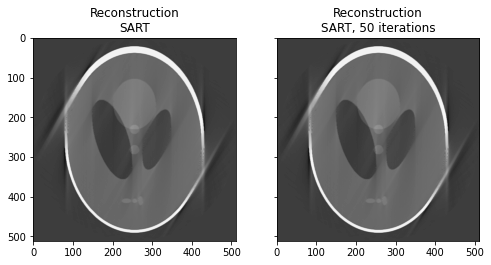

In [ ]:
from skimage.transform import iradon_sart

reconstruction_sart = iradon_sart(sinogram, theta=theta)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)

ax1.set_title("Reconstruction\nSART")
ax1.imshow(reconstruction_sart, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction\nSART, 50 iterations")
ax2.imshow(reconstruction_sart, cmap=plt.cm.Greys_r)
plt.show()
image_save = imsave('/content/gdrive/My Drive/CTrecon/deep.png', reconstruction_sart)

SART (1 iteration) rms reconstruction error: 0.0697
SART (2 iterations) rms reconstruction error: 0.0697


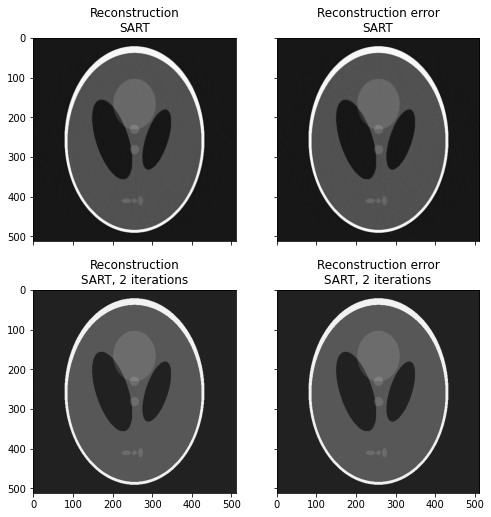

In [ ]:
from skimage.transform import iradon_sart

reconstruction_sart = iradon_sart(sinogram, theta=theta)
print("SART (1 iteration) rms reconstruction error: "
      f"{np.sqrt(np.mean(error**2)):.3g}")

fig, axes = plt.subplots(2, 2, figsize=(8, 8.5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].set_title("Reconstruction\nSART")
ax[0].imshow(reconstruction_sart, cmap=plt.cm.Greys_r)

ax[1].set_title("Reconstruction error\nSART")
ax[1].imshow(reconstruction_sart, cmap=plt.cm.Greys_r)

# Run a second iteration of SART by supplying the reconstruction
# from the first iteration as an initial estimate
reconstruction_sart2 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart)
reconstruction_sart2 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart)

reconstruction_sart3 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart2)

reconstruction_sart4 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart3)


reconstruction_sart5 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart4)


reconstruction_sart6 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart5)


reconstruction_sart7 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart6)


reconstruction_sart8 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart7)


reconstruction_sart9 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart8)


reconstruction_sart10 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart9)


reconstruction_sart11 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart10)

reconstruction_sart12 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart11)


reconstruction_sart13 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart12)


reconstruction_sart14 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart13)


reconstruction_sart15 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart14)

reconstruction_sart16 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart15)

reconstruction_sart17 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart16)

reconstruction_sart18 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart17)

reconstruction_sart19 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart18)

reconstruction_sart20 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart19)

reconstruction_sart21 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart20)

reconstruction_sart22 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart21)

reconstruction_sart23 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart22)

reconstruction_sart24 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart23)

reconstruction_sart25 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart24)

reconstruction_sart26 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart25)

reconstruction_sart27 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart26)

reconstruction_sart28 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart27)

reconstruction_sart29 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart28)

reconstruction_sart30 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart29)

reconstruction_sart31 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart30)

reconstruction_sart32 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart31)

reconstruction_sart33 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart32)

reconstruction_sart34 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart33)

reconstruction_sart35 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart34)

reconstruction_sart36 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart35)

reconstruction_sart37 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart36)

reconstruction_sart38 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart37)

reconstruction_sart39 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart38)

reconstruction_sart40 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart39)

reconstruction_sart41 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart40)

reconstruction_sart42 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart41)

reconstruction_sart43 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart42)

reconstruction_sart44 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart43)
reconstruction_sart45 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart44)

reconstruction_sart46 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart45)

reconstruction_sart47 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart46)

reconstruction_sart48 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart47)
reconstruction_sart49 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart48)
reconstruction_sart50 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart49)
print("SART (2 iterations) rms reconstruction error: "
      f"{np.sqrt(np.mean(error**2)):.3g}")

ax[2].set_title("Reconstruction\nSART, 2 iterations")
ax[2].imshow(reconstruction_sart50, cmap=plt.cm.Greys_r)

ax[3].set_title("Reconstruction error\nSART, 2 iterations")
ax[3].imshow(reconstruction_sart50, cmap=plt.cm.Greys_r)
plt.show()